<a href="https://colab.research.google.com/github/rebeccahe1998/E4511-2021-HE/blob/main/EDA_students_ampl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. For homework, you will work on this entire notebook for your own targets. Download your target related data from the following databases:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

## Install packages

In [1]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-03-14 16:55:10--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   191MB/s    in 2.7s    

2021-03-14 16:55:12 (191 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge
    bravado-core-5.17.0        |     pyh9f0ad1d_0          48 KB  co

In [2]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import io

In [3]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os

## Download/Load data

In [34]:
! wget https://github.com/rebeccahe1998/E4511-2021-HE/raw/main/DTC_SLC6A3.csv
! wget https://github.com/rebeccahe1998/E4511-2021-HE/raw/main/CHEBML_SLC6A3.csv
! wget https://github.com/rebeccahe1998/E4511-2021-HE/raw/main/EXCAPE_SLC6A3.csv

--2021-03-14 17:58:34--  https://github.com/rebeccahe1998/E4511-2021-HE/raw/main/DTC_SLC6A3.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/DTC_SLC6A3.csv [following]
--2021-03-14 17:58:34--  https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/DTC_SLC6A3.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2775736 (2.6M) [text/plain]
Saving to: ‘DTC_SLC6A3.csv’

DTC_SLC6A3.csv      100%[===================>]   2.65M  --.-KB/s    in 0.09s   

2021-03-14 17:58:34 (28.2 MB/s) - ‘DTC_SLC6A3.csv’ saved [2775736/2775736]

--2021-03-14 17:58:34--  http

In [71]:
dtc = pd.read_csv("DTC_SLC6A3.csv", sep=',', header=0 )
excape = pd.read_excel("EXCAPE_SLC6A3.csv")
chembl = pd.read_excel("CHEBML_SLC6A3.csv")

In [72]:
chembl.columns = chembl.columns.str.replace(' ','_')
print(chembl.shape)
dtc.columns = dtc.columns.str.replace(' ','_')
print(dtc.shape)
excape.columns = excape.columns.str.replace(' ','_')
print(excape.shape)

(8031, 45)
(7301, 33)
(111836, 11)


In [73]:
excape.iloc[1:3, 1:15]

,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
1,1778877,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O(C(=O)CCCCCCCC=C)C
2,123435,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,O1CCNCCOCCOCCNCC1


In [74]:
chembl.iloc[1:3, 1:10]

,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation
1,NaN,0,403.53,0,3.89,2c,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1,IC50,'='
2,NaN,0,487.97,0,2.22,15,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...,Inhibition,'='


# Examine data
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- Think about how we might combine these data sources together

In [75]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4095847,NaN,0,397.53,0,4.45,1q,c1ccc(CC2CCN(CCn3nnnc3-c3cccc4ccccc34)CC2)cc1,IC50,'>',10000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN
1,CHEMBL4099475,NaN,0,403.53,0,3.89,2c,CC(=O)c1cccc(-c2nnnn2CCCN2CCC(Cc3ccccc3)CC2)c1,IC50,'=',5040.0,nM,5.30,NaN,NaN,UO_0000065,13.13,0.24,1.41,8.29,False,CHEMBL4046313,Inhibition of re-uptake of [3H]-DA at human DA...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4043179,1,Scientific Literature,Bioorg Med Chem,2017.0,CHEMBL3307715,NaN
2,CHEMBL4072303,NaN,0,487.97,0,2.22,15,CNc1nc(C#Cc2ccc(Cl)s2)nc2c1ncn2[C@H]1[C@H](O)[...,Inhibition,'=',36.0,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4011334,"Inhibition of [3H]WIN35,428 binding to recombi...",B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4007505,1,Scientific Literature,J Med Chem,2017.0,CHEMBL3307715,NaN
3,CHEMBL272074,NaN,0,326.44,0,3.2,rac-6i,CCN(CC)C(=O)C1(c2ccccc2)CC1CNCc1ccco1,IC50,'>',10000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL932890,Inhibition of human DAT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1143218,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None,NaN
4,CHEMBL270607,NaN,0,399.92,0,3.77,9n,CNCc1cc(C(=O)N2CCN(C3CC3)CC2)ccc1Oc1cccc(Cl)c1,Ki,'=',7000.0,nM,5.16,NaN,NaN,UO_0000065,12.89,0.25,1.38,11.5,False,CHEMBL948194,Binding affinity to human DAT,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1141555,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2008.0,None,NaN


In [76]:
chembl.Standard_Type.value_counts()

IC50                                                   3367
Ki                                                     3031
Inhibition                                             1157
Activity                                                180
Ratio                                                    76
pKD                                                      56
Log 1/C                                                  50
EC50                                                     47
Kd                                                       21
% Ctrl                                                    8
% Inhibition of Control Specific Binding (Mean n=2)       8
Displacement                                              6
Ratio Ki                                                  4
IC5                                                       4
pKi                                                       3
Ratio IC50                                                2
Efficacy                                

## Exercise: Explore datasets
- explore the loaded dtc and excape dataframes
- answer the following questions

## Questions

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?

What other information might be useful?

In [77]:
dtc.standard_type.value_counts()# assay response types

IC50                    3050
KI                      2985
INHIBITION               851
ACTIVITY                 118
RATIO                     76
PKD                       56
LOG 1/C                   50
Ki                        49
KD                        20
EC50                      10
Inhibition                 7
IC5                        4
RATIO KI                   4
DISPLACEMENT               4
Activity                   4
PKI                        3
EFFICACY                   2
INH                        1
SELECTIVITY RATIO          1
DISCRIMINATION RATIO       1
AFFINITY                   1
Name: standard_type, dtype: int64

In [78]:
excape.pXC50.value_counts()# assay response values only ic and ec50

7.80000    40
8.00000    38
7.00000    36
5.00000    32
7.60000    31
           ..
6.01412     1
8.55284     1
7.63264     1
7.34008     1
5.80743     1
Name: pXC50, Length: 1253, dtype: int64

In [79]:
print('CHEMBL',chembl.Standard_Units.unique()) #type of variable are the data responses
print('\nDTC', dtc.standard_units.unique())

CHEMBL ['nM' '%' nan 'uM' 'ug.mL-1']

DTC ['NM' nan '%' 'UG.ML-1']


# EDA: assay data responses questions
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

## **Curation step**: change units to be the same for all responses

In [80]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

## EDA: Summarize, describe, plot data for analysis

In [105]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Source_ID,Document_Year,Standard_Value_nM
count,8031.000000,8006.000000,7860.000000,7860.000000,6.029000e+03,3870.000000,3724.000000,3665.000000,3665.000000,3661.000000,8031.000000,6097.000000,6.029000e+03
mean,0.810360,349.454393,0.232443,3.510851,5.155393e+11,6.650450,20.598550,0.413675,2.644917,36.866878,6.133109,2009.320485,5.155393e+11
std,1.584411,134.682903,0.528646,1.669411,1.620094e+13,1.130844,5.571761,0.111730,1.594709,49.883078,10.639061,5.132397,1.620094e+13
min,0.000000,32.050000,0.000000,-13.050000,-6.390000e+01,4.010000,3.080000,0.120000,-4.180000,2.670000,1.000000,1979.000000,-6.390000e+01
25%,0.000000,279.860000,0.000000,2.660000,2.300000e+01,5.750000,16.755000,0.330000,1.650000,14.430000,1.000000,2007.000000,2.300000e+01
50%,0.000000,322.240000,0.000000,3.590000,1.500000e+02,6.570000,20.380000,0.410000,2.660000,21.770000,1.000000,2009.000000,1.540000e+02
75%,0.000000,395.430000,0.000000,4.490000,2.250000e+03,7.460000,24.450000,0.490000,3.750000,32.930000,15.000000,2013.000000,2.250000e+03
max,4.000000,2296.970000,4.000000,12.390000,9.120108e+14,10.230000,56.250000,1.040000,7.530000,298.070000,54.000000,2020.000000,9.120108e+14



Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries

In [82]:
chembl=chembl.replace('None',np.nan)

In [83]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

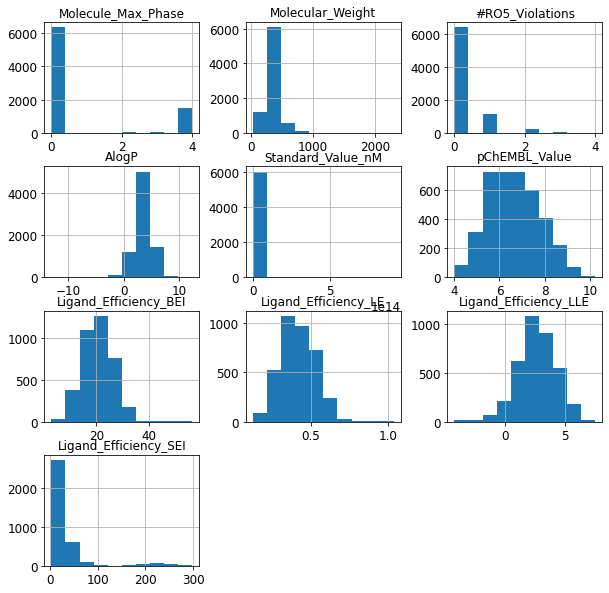

In [84]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

Standard_Type,% Ctrl,% Inhibition of Control Specific Binding (Mean n=2),Activity,Affinity,Discrimination ratio,Displacement,EC50,Efficacy,IC5,IC50,INH,Inhibition,Kd,Ki,Log 1/C,Ratio,Ratio IC50,Ratio Ki,Selectivity ratio,pKD
count,7.000000,8.000000,113.000000,1.00,1.00,4.0,30.000000,2.00000,4.00000,2033.000000,1.0,857.000000,21.000000,1.783000e+03,46.000000,72.000000,1.0,2.00000,1.00,52.000000
mean,78.285714,17.612500,373.553982,5.28,0.25,200.0,2076.497667,75.60000,4181.00000,6045.760058,16000.0,31.211301,7503.390476,1.380877e+12,6.528732,6.224375,15.0,31.25000,0.62,7.099231
std,28.703741,12.021105,1938.849432,NaN,NaN,0.0,4515.171864,22.91026,4834.75432,22786.390229,NaN,32.567748,11561.751403,2.675066e+13,0.602333,12.991079,NaN,22.98097,NaN,0.779474
min,28.000000,2.200000,0.000000,5.28,0.25,200.0,12.500000,59.40000,48.00000,0.002000,16000.0,-63.900000,1.200000,0.000000e+00,5.210000,0.020000,15.0,15.00000,0.62,5.660000
25%,62.000000,5.475000,7.000000,5.28,0.25,200.0,234.187500,67.50000,280.50000,90.000000,16000.0,5.210000,200.000000,4.500000e+01,6.105000,0.985000,15.0,23.12500,0.62,6.340000
50%,91.000000,20.950000,21.000000,5.28,0.25,200.0,577.500000,75.60000,3338.00000,800.000000,16000.0,25.800000,1080.000000,4.610000e+02,6.615000,1.750000,15.0,31.25000,0.62,7.260000
75%,99.500000,26.775000,64.000000,5.28,0.25,200.0,1045.000000,83.70000,7238.50000,5923.333333,16000.0,50.000000,9300.000000,3.580000e+03,6.910000,4.525000,15.0,39.37500,0.62,7.642500
max,106.000000,31.600000,17700.000000,5.28,0.25,200.0,22908.680000,91.80000,10000.00000,744000.000000,16000.0,105.000000,42000.000000,9.120108e+14,7.800000,76.800000,15.0,47.50000,0.62,8.420000


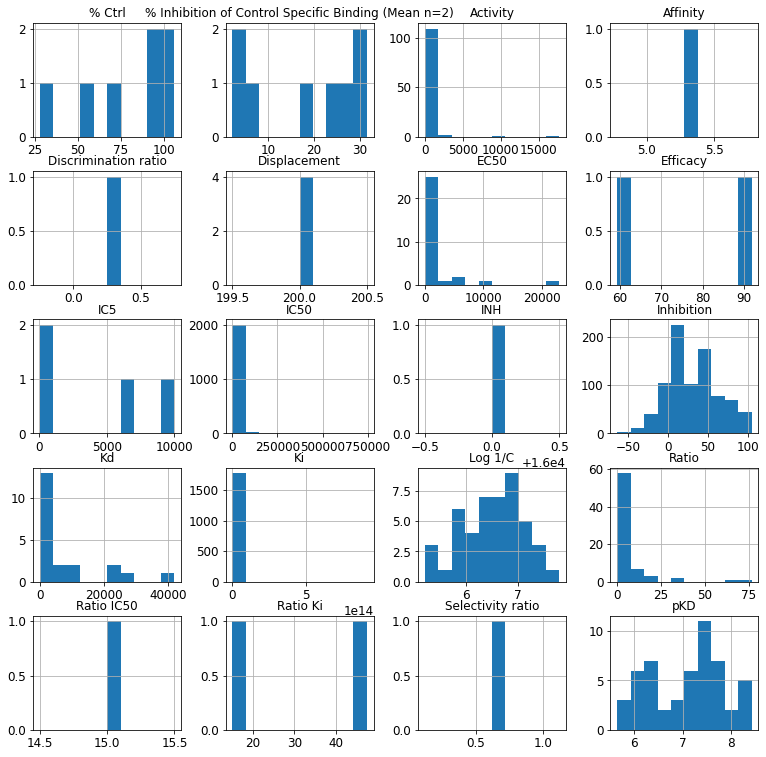

In [85]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

 What do you notice about the standard values?

Standard_Type,EC50,IC50,Kd,Ki
count,25.000000,1642.000000,21.000000,1470.000000
mean,6.397000,6.488622,5.966667,6.732454
std,0.791579,1.106943,1.166218,1.117893
min,4.640000,4.040000,4.380000,4.010000
25%,5.950000,5.620000,5.030000,5.760000
50%,6.400000,6.440000,5.970000,6.695000
75%,7.025000,7.237500,6.700000,7.550000
max,7.900000,10.230000,8.920000,9.920000


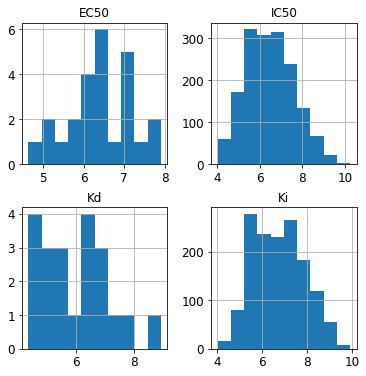

In [86]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));
# ic50 and ec50, ki are normal

- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way
- **Curation step:** add pValue column from raw measurements if it doesn't exist

In [94]:
# transform the response value
# DTC ['NM' nan '%' 'UG.ML-1']
dtc['pDTC_Value'] = np.where(dtc.standard_units == 'NM',
                                           -np.log10(dtc.standard_value/1000000000),
                                           dtc.standard_value)

standard_type,ACTIVITY,AFFINITY,Activity,DISCRIMINATION RATIO,DISPLACEMENT,EC50,EFFICACY,IC5,IC50,INH,INHIBITION,Inhibition,KD,KI,Ki,LOG 1/C,PKD,RATIO,RATIO KI,SELECTIVITY RATIO
count,88.000000,1.00,4.000000,1.00,4.0,10.000000,2.00000,4.00000,1781.000000,1.0,638.000000,6.000000,20.00000,1.690000e+03,46.000000,46.000000,52.000000,72.000000,2.00000,1.00
mean,374.521970,5.28,88.375000,0.25,200.0,4053.848000,75.60000,4181.00000,4716.506430,16000.0,31.200959,41.450000,7868.56000,1.456867e+12,3622.441957,6.528732,7.099231,6.224375,31.25000,0.62
std,2179.142973,NaN,79.245794,NaN,0.0,7002.985707,22.91026,4834.75432,20755.313775,NaN,31.555676,22.530313,11737.20002,2.747525e+13,18804.518572,0.602333,0.779474,12.991079,22.98097,NaN
min,0.000000,5.28,13.500000,0.25,200.0,24.800000,59.40000,48.00000,0.002000,16000.0,-63.900000,16.200000,1.20000,1.200000e-01,0.910000,5.210000,5.660000,0.020000,15.00000,0.62
25%,5.000000,5.28,50.625000,0.25,200.0,537.750000,67.50000,280.50000,72.000000,16000.0,6.000000,25.875000,293.75000,5.012000e+01,22.200000,6.105000,6.340000,0.985000,23.12500,0.62
50%,13.000000,5.28,70.000000,0.25,200.0,991.000000,75.60000,3338.00000,540.000000,16000.0,24.550000,40.000000,2290.00000,5.011900e+02,112.000000,6.615000,7.260000,1.750000,31.25000,0.62
75%,36.500000,5.28,107.750000,0.25,200.0,4377.500000,83.70000,7238.50000,4300.000000,16000.0,50.000000,50.000000,9975.00000,4.130500e+03,1000.000000,6.910000,7.642500,4.525000,39.37500,0.62
max,17700.000000,5.28,200.000000,0.25,200.0,22908.680000,91.80000,10000.00000,744000.000000,16000.0,103.000000,78.000000,42000.00000,9.120108e+14,128000.000000,7.800000,8.420000,76.800000,47.50000,0.62


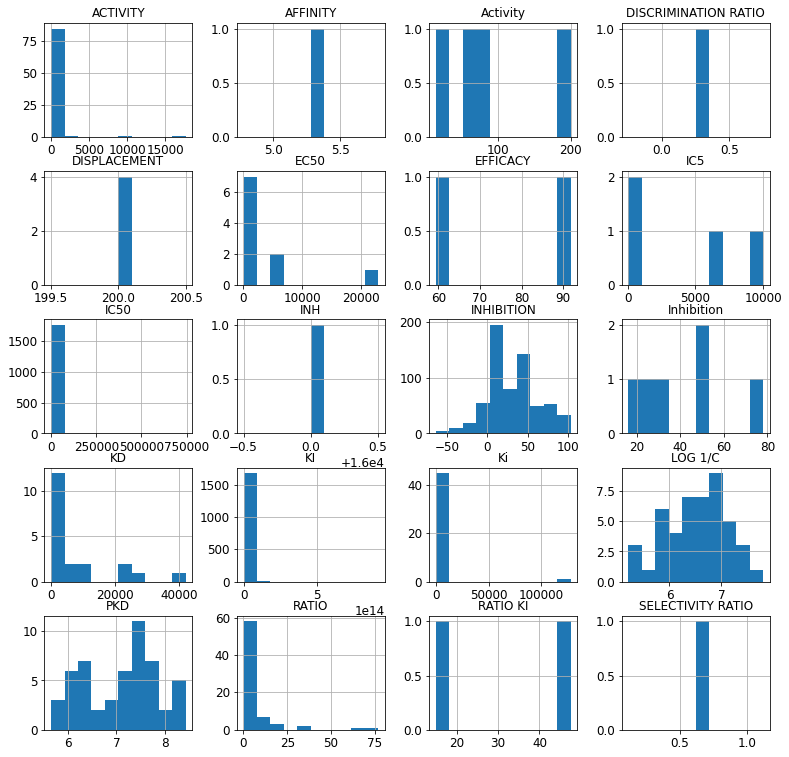

In [92]:
dtc_types=dtc.pivot_table(index = 'compound_id', columns = 'standard_type', values='standard_value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(13,13));

In [115]:
dtc=dtc.replace('None',np.nan)
dtc.columns

Index(['compound_id', 'standard_inchi_key', 'compound_name', 'synonym',
       'target_id', 'target_pref_name', 'gene_names', 'wildtype_or_mutant',
       'mutation_info', 'pubmed_id', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'activity_comment',
       'ep_action_mode', 'assay_format', 'assaytype', 'assay_subtype',
       'inhibitor_type', 'detection_tech', 'assay_cell_line',
       'compound_concentration_value', 'compound_concentration_value_unit',
       'substrate_type', 'substrate_relation', 'substrate_value',
       'substrate_units', 'assay_description', 'title', 'journal', 'doc_type',
       'annotation_comments', 'pDTC_Value'],
      dtype='object')

standard_type,ACTIVITY,AFFINITY,Activity,DISCRIMINATION RATIO,DISPLACEMENT,EC50,EFFICACY,IC5,IC50,INH,INHIBITION,Inhibition,KD,KI,Ki,LOG 1/C,PKD,RATIO,RATIO KI,SELECTIVITY RATIO
count,88.000000,1.00,4.000000,1.00,4.0,10.000000,2.00000,4.000000,1781.000000,1.00000,638.000000,6.000000,20.000000,1690.000000,46.000000,46.000000,52.000000,72.000000,2.00000,1.00
mean,133.617473,5.28,88.375000,0.25,200.0,5.921283,75.60000,5.991074,6.351458,4.79588,31.200959,41.450000,5.929488,6.288487,6.892800,6.528732,7.099231,6.224375,31.25000,0.62
std,1064.067662,NaN,79.245794,NaN,0.0,0.807787,22.91026,1.092208,1.175989,NaN,31.555676,22.530313,1.184558,1.690650,1.144522,0.602333,0.779474,12.991079,22.98097,NaN
min,0.000000,5.28,13.500000,0.25,200.0,4.640000,59.40000,5.000000,0.050000,4.79588,-63.900000,16.200000,4.376751,-5.960000,3.892790,5.210000,5.660000,0.020000,15.00000,0.62
25%,5.000000,5.28,50.625000,0.25,200.0,5.393832,67.50000,5.149565,5.366532,4.79588,6.000000,25.875000,5.003842,5.402855,6.000000,6.105000,6.340000,0.985000,23.12500,0.62
50%,11.000000,5.28,70.000000,0.25,200.0,6.003944,75.60000,5.822769,6.293282,4.79588,24.550000,40.000000,5.711254,6.311746,6.951632,6.615000,7.260000,1.750000,31.25000,0.62
75%,28.250000,5.28,107.750000,0.25,200.0,6.272687,83.70000,6.664277,7.173925,4.79588,50.000000,50.000000,6.553808,7.322072,7.660414,6.910000,7.642500,4.525000,39.37500,0.62
max,10000.000000,5.28,200.000000,0.25,200.0,7.605548,91.80000,7.318759,11.698970,4.79588,103.000000,78.000000,8.920819,9.920819,9.040959,7.800000,8.420000,76.800000,47.50000,0.62


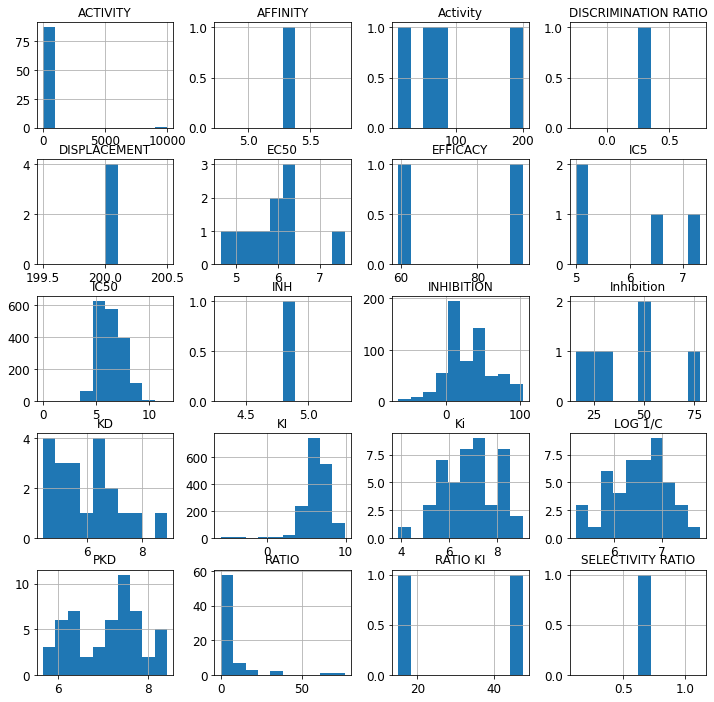

In [114]:
# Use p_DCT value 
dtc_types=dtc.pivot_table(index = 'compound_id', columns = 'standard_type', values='pDTC_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(12,12));
# ec50 and ic50 looks a little bit more normal

,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,111836.000000,5292.000000,1.118360e+05,111836.000000,111836.0
mean,6988.297802,6.795182,4.456107e+05,9618.775636,4060.0
std,2858.314323,1.218889,6.742001e+04,79.681560,0.0
min,6531.000000,2.140000,4.933600e+04,9606.000000,4060.0
25%,6531.000000,5.850000,4.497680e+05,9606.000000,4060.0
50%,6531.000000,6.790000,4.497680e+05,9606.000000,4060.0
75%,6531.000000,7.700000,4.497680e+05,9606.000000,4060.0
max,24898.000000,11.700000,1.367804e+06,10116.000000,4060.0


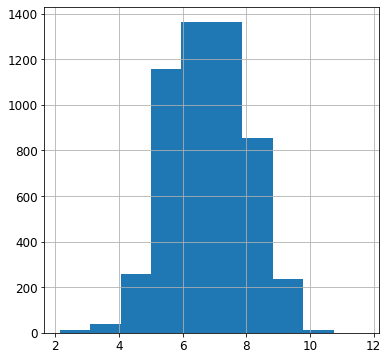

In [99]:
display(excape.describe())
excape.pXC50.hist(figsize=(6,6))


## EDA & Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns


In [128]:
pdtc50 = dtc.loc[(dtc['standard_type'] == 'IC50') | (dtc['standard_type'] =='EC50'),"pDTC_Value"]

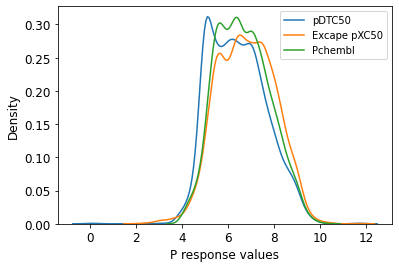

In [131]:
sns.kdeplot(pdtc50, label = 'pDTC50')
sns.kdeplot(excape['pXC50'], label='Excape pXC50')
sns.kdeplot(chembl['pChEMBL_Value'], label='Pchembl')
plt.xlabel('P response values')
plt.legend()

## Exercise: analyze & discuss
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

# EDA: Compounds
- make sure smiles strings exist since that's what AMPL uses
- compare compounds in each dataset
- featurize with ECFP fingerprints
- examine diversity of compound set

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets/excel or from the LHS folder menu, right-click on the "HTR3A_DTC.csv" file to download it to your computer and open the file with Excel. 
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi  (use highlight and click on "Follow-link" option to open the link in your browser)
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

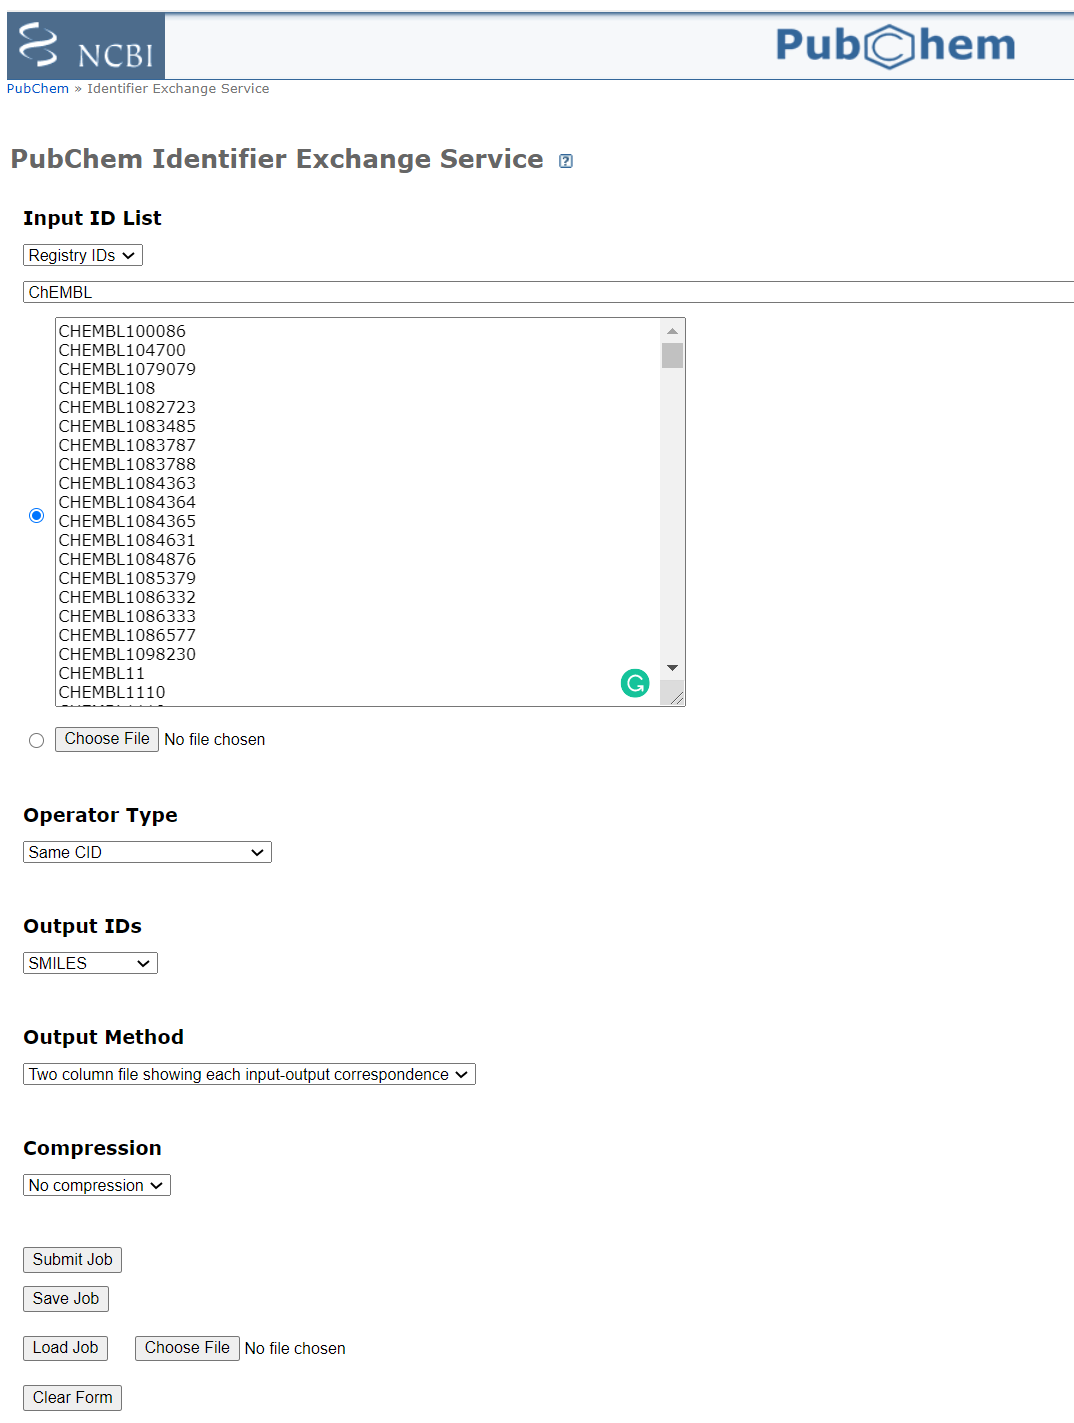

In [ ]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/Img/PubChemCIDExchange.png", 
      width = 900, height = 900)

## Note, the output from PubChem Identifier Exchange Service can be uploaded into the left hand window of COLAB by dragging and dropping the file. In my case the output file is, 

In my case, I have saved the file in Github and I am uploading it. 

In [132]:
! wget https://github.com/rebeccahe1998/E4511-2021-HE/raw/main/dtc_smiles_file

--2021-03-14 20:00:53--  https://github.com/rebeccahe1998/E4511-2021-HE/raw/main/dtc_smiles_file
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/dtc_smiles_file [following]
--2021-03-14 20:00:53--  https://raw.githubusercontent.com/rebeccahe1998/E4511-2021-HE/main/dtc_smiles_file
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 458641 (448K) [text/plain]
Saving to: ‘dtc_smiles_file’

dtc_smiles_file     100%[===================>] 447.89K  --.-KB/s    in 0.03s   

2021-03-14 20:00:53 (17.1 MB/s) - ‘dtc_smiles_file’ saved [458641/458641]



In [134]:
# open file from pubchem ID exchange service
dtc_smiles = pd.read_csv("dtc_smiles_file", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL336100,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F
1,CHEMBL336100,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F
2,CHEMBL336100,C1CN2C(=N1)C3=C(C2(C4=CC=C(C=C4)Cl)O)C=CC=C3F
3,CHEMBL14144,CN1C2CCC1C(C(C2)C3=CC=C(C=C3)Cl)C(=O)OC4=CC=CC=C4
4,CHEMBL3323101,CN1CC(C2=CC=CC=C2C1)C3=CC4=C(C=C3)NC=C4


In [135]:
# map chembl id to smiles using a dict
# zip the above two series as a dictionary and map smiles according to compound id
dtc['SMILES'] = dtc['compound_id'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [137]:
# what's missing?
print("No ChemblID in DTC:", sum(dtc['compound_id'].isna()))
print("No SMILES from ChemblID in DTC:", sum(dtc.SMILES.isna()))

No ChemblID in DTC: 16
No SMILES from ChemblID in DTC: 117


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [ ]:
# use standard inchi key to find smiles 

In [148]:
inchikey = dtc.loc[dtc['SMILES'].isna(),'standard_inchi_key']
inchikey[inchikey.isna()==False].values
# however, the result is empty 

array(['ABZSPJVXTTUFAA-UHFFFAOYSA-N', 'ABZSPJVXTTUFAA-UHFFFAOYSA-N',
       'DYIRSNMPIZZNBK-UHFFFAOYSA-N', 'DZTZPWDKQRGFKW-UHFFFAOYSA-N',
       'HXTGXYRHXAGCFP-UHFFFAOYSA-N', 'IHIXIJGXTJIKRB-UHFFFAOYSA-N',
       'IHIXIJGXTJIKRB-UHFFFAOYSA-N', 'KIWQWJKWBHZMDT-GSVOUGTGSA-N',
       'LPLLVINFLBSFRP-UHFFFAOYSA-N', 'MYWUZJCMWCOHBA-UHFFFAOYSA-N',
       'PDNJLMZEGXHSCU-GSVOUGTGSA-N', 'SVFXPTLYMIXFRX-CJNGLKHVSA-N',
       'SVFXPTLYMIXFRX-CJNGLKHVSA-N', 'SVFXPTLYMIXFRX-CJNGLKHVSA-N',
       'SVFXPTLYMIXFRX-CJNGLKHVSA-N', 'SVFXPTLYMIXFRX-CJNGLKHVSA-N',
       'UBIQMAFTTDZGEX-UHFFFAOYSA-N', 'VBOQYPQEPHKASR-GSVOUGTGSA-N',
       'VBOQYPQEPHKASR-UHFFFAOYSA-N', 'VQOXZBDYSJBXMA-VHFLTRTASA-N',
       'VQOXZBDYSJBXMA-VHFLTRTASA-N', 'ZRGONKKAENTXKT-ZBOSIHDASA-N'],
      dtype=object)

## EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

In [150]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

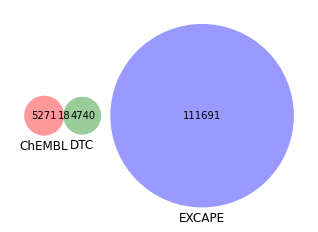

In [151]:
# overlaps from SMILES strings
venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists

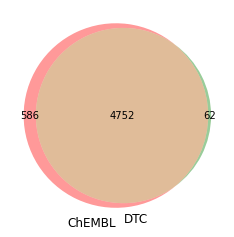

In [154]:
# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists
venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.compound_id)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without base smiles

In [155]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

8031
5289
5251


In [ ]:
chembl[chembl.base_rdkit_smiles=='']

In [157]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
158,CHEMBL611999,"Rutheium (II) triflate salt of (methyl (3S,5R)...",0.0,645.73,NaN,NaN,4,NaN,IC50,'=',3890.00,nM,5.41,NaN,NaN,UO_0000065,8.38,NaN,NaN,NaN,False,CHEMBL671771,Inhibitory activity against [3H]-Dopamine upta...,B,BAO_0000221,tissue-based format,Rattus norvegicus,CHEMBL3638267,Caudate-putamen,NaN,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1129546,1,Scientific Literature,J. Med. Chem.,1996.0,NaN,NaN,3890.00,NaN
274,CHEMBL1909064,LIPOPOLYSACCHARIDE E. COLI O55:B5,0.0,NaN,NaN,NaN,LIPOPOLYSACCHARIDE E. COLI O55:B5,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909143,DRUGMATRIX: Dopamine Transporter radioligand b...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN,NaN,NaN
351,CHEMBL326945,Rhenium complex,0.0,692.90,NaN,NaN,14a (O-1768),NaN,IC50,'=',660.00,nM,6.18,NaN,NaN,UO_0000065,8.92,NaN,NaN,NaN,False,CHEMBL669521,In vitro affinity for dopamine transporter in ...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,660.00,NaN
395,CHEMBL326165,N-[(2-((3'-N-propyl-(1''R) -3''beta-(4-fluorop...,0.0,694.91,NaN,NaN,12a (O-1505),NaN,IC50,'=',2.05,nM,8.69,NaN,NaN,UO_0000065,12.50,NaN,NaN,NaN,False,CHEMBL669521,In vitro affinity for dopamine transporter in ...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,2.05,NaN
404,CHEMBL1909056,COBALT(II) ACETYLACETONATE,0.0,257.15,NaN,NaN,COBALT(II) ACETYLACETONATE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909143,DRUGMATRIX: Dopamine Transporter radioligand b...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3307512,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7308,CHEMBL119561,O-1186,0.0,696.88,NaN,NaN,27a-1 (O-927),NaN,IC50,'=',7.40,nM,8.13,NaN,NaN,UO_0000065,11.67,NaN,NaN,NaN,False,CHEMBL669521,In vitro affinity for dopamine transporter in ...,B,BAO_0000357,single protein format,Cercopithecidae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1145865,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,7.40,NaN
7329,CHEMBL3559671,POLYVINYL ALCOHOL,4.0,NaN,NaN,NaN,POLYVINYL ALCOHOL,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909143,DRUGMATRIX: Dopamine Transporter radioligand b...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,CHO-K1,Membrane,NaN,NaN,NaN,CHEMBL238,Dopamine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,Dr

In [158]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]  # DROP ALL EMPTY rdkitsmiles

## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [160]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(curate_data.base_smiles_from_smiles)
print(len(excape.SMILES))
print(len(excape.SMILES.unique()))
print(len(excape.base_rdkit_smiles.unique()))
# some rdkit smiles correspond to different smiles

111836
111691
111601


In [161]:
excape[excape.base_rdkit_smiles.duplicated(keep=False)].sort_values('base_rdkit_smiles') 
# we can see same rdkit smiles but smiles different

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
6747,DAPCKNJKGASBHF-UHFFFAOYNA-N,5389047,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,S1C(=N(O)=CC=2SC=CC2)C(N(C1=S)C)(C)C,
19214,KZGDMAUPNOGKOX-UHFFFAOYNA-N,5389051,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,S1C(=N(O)=CC2=CC=CN=C2)C(N(C1=S)C)(C)C,
20603,NWRFMJSGZCVERY-UHFFFAOYNA-N,9551615,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,S1C(=N(O)=CC=2C=CC=CC2)C(N(C1=S)C)(C)C,
15659,AJXKLHFIQDVGJG-UHFFFAOYNA-N,5389055,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,S1C(C(N(C1=S)C)=N(O)=CC2=CC=CN=C2)(C)C,
85382,ZYWULSRYZLJMEE-UHFFFAOYNA-N,371204,6531,N,NaN,pubchem_screening,449768,9606,SLC6A3,4060,ON1=2C(CC3=C(C1)C(OC)=C(OC)C=C3)C=4C(CC2)=CC(O...,
...,...,...,...,...,...,...,...,...,...,...,...,...
14308,ZWLWOTHDIGRTNE-UHFFFAOYNA-N,CHEMBL150045,6531,A,7.10000,chembl20,62820,9606,SLC6A3,4060,C(C1=CC=NC=C1)(C2=CC=CC=C2)C3=CC=CC=C3,c1ccc(C(c2ccccc2)c2ccncc2)cc1
80471,RAQPOZGWANIDQT-UHFFFAOYNA-N,3456,24898,A,8.43180,pubchem,180512,10116,SLC6A3,4060,O(CCN1CCN(CC1)CCCC2=CC=CC=C2)C(C3=CC=CC=C3)C4=...,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1
80472,RAQPOZGWANIDQT-UHFFFAOYNA-N,CHEMBL26320,6531,A,8.43000,chembl20,532579,9606,SLC6A3,4060,C=1C=CC(=CC1)C(C=2C=CC=CC2)OCCN3CCN(CC3)CCCC4=...,c1ccc(CCCN2CCN(CCOC(c3ccccc3)c3ccccc3)CC2)cc1
22491,RGSVXQJPSWZXOP-UHFFFAOYNA-N,CHEMBL279556,6531,A,8.66000,chembl20,762026,9606,SLC6A3,4060,N1(CCCCC1)C2(CCCCC2)C3=CC=4C(S3)=CC=CC4,c1ccc2sc(C3(N4CCCCC4)CCCCC3)cc2c1


In [162]:
# drop empty rdkit smilees for excape and dtc
excape=excape.replace('',np.nan)
excape=excape[~excape.base_rdkit_smiles.isna()] # DROP ALL EMPTY rdkitsmiles

In [164]:

dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
dtc=dtc.replace('',np.nan)
dtc=dtc[~dtc.base_rdkit_smiles.isna()]
print(len(dtc.SMILES))
print(len(dtc.SMILES.unique()))
print(len(dtc.base_rdkit_smiles.unique()))

7184
4757
4724


In [166]:
! pwd

/content


## **Curation step:** Save standardized datasets

In [167]:
chembl.to_csv("/content/drive/MyDrive/ChEMBL_SLC6A3_SMILES.csv")
dtc.to_csv("/content/drive/MyDrive/DTC_SLC6A3_SMILES.csv")
excape.to_csv("/content/drive/MyDrive/EXCAPE_SLC63_SMILES.csv")

## Exercise: examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

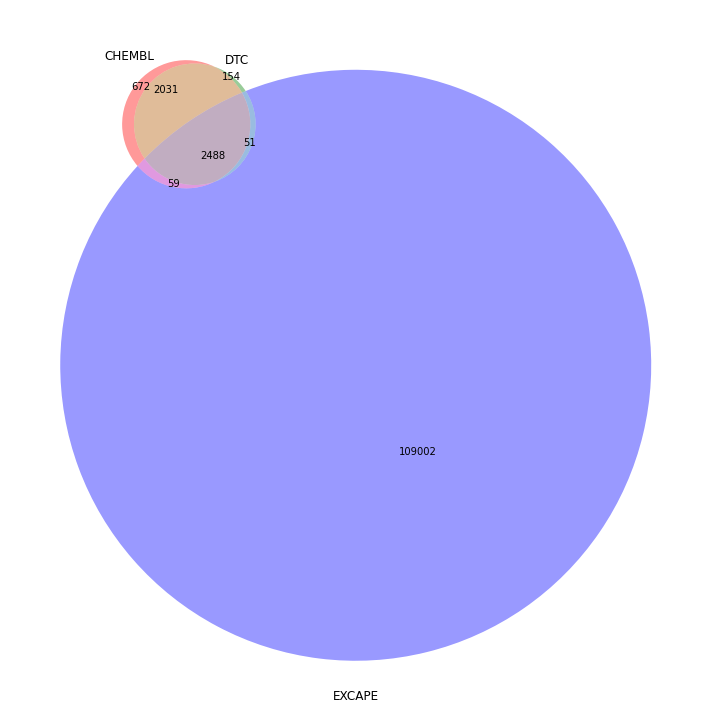

In [169]:
plt.figure(figsize=(13,13))
venn3([set(chembl.base_rdkit_smiles),set(dtc.base_rdkit_smiles),set(excape.base_rdkit_smiles)],set_labels=['CHEMBL','DTC','EXCAPE'])


## EDA: Examine compound diversity

In [ ]:
import diversity_plots as dp
sns.set_context('poster')

In [ ]:
dp.plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

In [ ]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/HTR3A_ChEMBL_SMILES.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')

## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?